In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import torch.nn.init as init

import torch.utils.data as Data
import torchvision.datasets as dset
from torchvision.transforms import ToTensor

In [2]:
DOWNLOAD_CIFAR10 = False

if not(os.path.exists('./cifar10/')) or not os.listdir('./cifar10/'):
    # not cifar10 dir or cifar10 is empyt dir
    DOWNLOAD_CIFAR10 = True

train_set = dset.CIFAR10('./cifar10', train=True, transform=ToTensor(), download=DOWNLOAD_CIFAR10)

(50000, 32, 32, 3)
50000


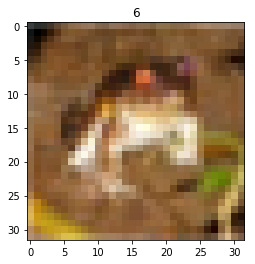

In [3]:
print(train_set.train_data.shape) # (50000, 32, 32, 3)
print(len(train_set.train_labels)) # (50000)
plt.title('%i' % train_set.train_labels[0])
plt.imshow(train_set.train_data[0])
plt.show()

In [4]:
BATCH_SIZE = 80

train_loader = Data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
class VAE(nn.Module):
    def __init__(self, embed_dim):
        """
        :param embed_dim: dimension of the hidden space, integer
        """
        super(VAE, self).__init__()
        self.embed_dim = embed_dim
        
        # encoding preprocessing
        self.conv_1_enc = nn.Conv2d(3, 3, kernel_size=2, stride=1)
        self.conv_2_enc = nn.Conv2d(3, 32, kernel_size=2, stride=2)
        self.conv_3_enc = nn.Conv2d(32, 32, kernel_size=2, stride=1)
        
        # encoding
        self.enc2med = nn.Linear(6272, 256)
        self.med2mu_enc = nn.Linear(256, embed_dim)
        self.med2log_var_enc = nn.Linear(256, embed_dim)
        
        # decoding
        self.sample2med = nn.Linear(embed_dim, 256)
        self.med2mu_dec = nn.Linear(256, 6272)
        
        # decoding postprocessing
        self.conv_1_dec = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=1)
        self.conv_2_dec = nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2)
        self.conv_3_dec = nn.ConvTranspose2d(3, 3, kernel_size=3, stride=1)
        
        self.init_weights()
    
    def preprocess(self, x):
        """
        Applies a few convolutional layers on the input image
        
        :param x: inputs, Variable of shape (batch_size, 3, 32, 32)
        :return: processed image, Variable of shape (batch_size, 32, 14, 14)
        """
        conv_1 = F.relu(self.conv_1_enc(x))
        conv_2 = F.relu(self.conv_2_enc(conv_1))
        conv_3 = F.relu(self.conv_3_enc(conv_2))
        return conv_3
    
    def encode(self, x):
        """
        Retrieves hidden distribution params from the input image
        
        :param x: inputs, Variable of shape (batch_size, 3, 32, 32)
        :return: mean and log_std for the hidden normal distribution, 
        two Variables of shapes (batch_size, embed_dim)
        """
        flattened = x.view(x.size()[0],-1)
        med = F.relu(self.enc2med(flattened))
        return self.med2mu_enc(med), self.med2log_var_enc(med)
    
    def decode(self, z):
        """
        Decodes image distribution params from the sampled hidden state
        
        :param z: inputs, Variable of shape (batch_size, embed_dim)
        :return: mean and log_std for the image normal distribution,
        two Variables of shapes (batch_size, 32, 14, 14)
        """
        med = F.relu(self.sample2med(z))
        mu_dec = self.med2mu_dec(med)
        mu_dec = mu_dec.view(mu_dec.size()[0], 32, 14, 14)
        return mu_dec
    
    def postprocess(self, x):
        """
        Applies a few convolutional layers on the generated image
        
        :param x: inputs, Variable of shape (batch_size, 32, 14, 14)
        :return: processed image, Variable of shape (batch_size, 3, 32, 32)
        """
        deconv_1 = self.conv_1_dec(x)
        deconv_2 = self.conv_2_dec(deconv_1)
        deconv_3 = self.conv_3_dec(deconv_2)
        return deconv_3
    
    def reparametrize(self, mu, log_var):
        """
        Performs reparametrization trick to sample data
        
        :param mu: mean of the desired distribution, Variable of shape (batch_size, embed_dim)
        :param log_var: log_std of the desired distribution, 
        Variable of shape (batch_size, embed_dim)
        :return: samples, Variable of shape (batch_size, embed_dim)
        """
        standard_normal = Normal(torch.zeros(mu.size()[0], self.embed_dim), 
                                      torch.ones(mu.size()[0], self.embed_dim))
        r = Variable(standard_normal.sample(), requires_grad=False)
        return r * torch.exp(0.5 * log_var) + mu
    
    def forward(self, x):
        """
        Encodes input to get mean and std of hidden representations,
        and then decodes a sample from them
        
        :param x: inputs, Variable of shape (batch_size, 3, 32, 32)
        :return: post-processed mean and log_std for the image normal distribution,
        two Variables of shapes (batch_size, 3, 32, 32)
        """
        processed = self.preprocess(x)
        self.mu_enc, self.log_var_enc = self.encode(processed)
        
        sample_z = self.reparametrize(self.mu_enc, self.log_var_enc)
        
        self.mu_dec = self.decode(sample_z)
        
        postprocessed = self.postprocess(self.mu_dec)
        return postprocessed
    
    def vae_loss(self, prediction, target):
        """
        Computes reconstruction loss, given prediction and target.
        IMPORTANT! Assumes that the prediction was already fed through the forward
        and self.mu_enc, self.log_var_enc, self.log_var_dec stores relevant values
        
        :param prediction: reconstructed image, Variable of shape (batch_size, 3, 32, 32)
        :param target: ground-truth image, Variable of shape (batch_size, 3, 32, 32)
        :return: averaged accross batches loss, float Variable of shape (1,)
        """
        flattened_y_hat = prediction.view(prediction.size()[0],-1)
        flattened_y = target.view(target.size()[0],-1)
        
        l2_loss = 0.5 * torch.sum((flattened_y_hat - flattened_y)**2, dim=1)
        
        kl_loss = -0.5 * torch.sum(1 + self.log_var_enc - self.mu_enc**2 - 
                                   self.log_var_enc.exp(), dim=1)
        
        return torch.mean(l2_loss + kl_loss)
    
    def generate(self, z):
        """
        Generates an example with selected hidden sample
        
        :param z: hidden sample, Variable of shape (embed_dim,)
        :return: generated image, Variable of shape (32, 32, 3)
        """
        ex_mu = self.decode(z)
        
        generated = self.postprocess(ex_mu)
        return generated.permute(0, 2, 3, 1)
    
    def init_weights(self):
        """
        Initialize weights of the model
        """
        relu_gain = init.calculate_gain('relu')
        
        init.xavier_uniform(self.enc2med.weight, relu_gain)
        init.xavier_uniform(self.med2mu_enc.weight)
        init.xavier_uniform(self.med2log_var_enc.weight)
        
        init.xavier_uniform(self.sample2med.weight, relu_gain)
        init.xavier_uniform(self.med2mu_dec.weight)

In [8]:
autoencoder = VAE(10)

optimizer = optim.SGD(autoencoder.parameters(), lr=1e-3)

In [9]:
N_EPOCHS = 50

for epoch in range(N_EPOCHS):
    print('-'*10)
    print('EPOCH:', epoch)
    avg_loss = 0
    
    for batch_ix, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        normed_x, target = Variable(x), Variable(target)
        
        out = autoencoder(normed_x)
        loss = autoencoder.vae_loss(out, normed_x)
        
        avg_loss += loss.data[0]
        loss.backward()
        optimizer.step()
        
        if (batch_ix+1) % 100 == 0 or (batch_ix+1) == len(train_loader):
            print('batch index:', batch_ix+1, '\t current train loss:', 
                  len(train_loader)*avg_loss/(batch_ix+1))

----------
EPOCH: 0
batch index: 100 	 current train loss: 62005.48138618469


KeyboardInterrupt: 

In [24]:
for batch_ix, (x, target) in enumerate(train_loader):
    if batch_ix == 1:
        break
    
    normed_x, target = Variable(x), Variable(target)
        
    out = autoencoder(normed_x)
    
    fwd = autoencoder.preprocess(normed_x)
    fwd = autoencoder.encode(fwd)
    
    loss = autoencoder.vae_loss(out, normed_x)
    
    ex_out = out.data[5,:,:,:].numpy()
    ex_x = normed_x.data[5,:,:,:].numpy()
    print(loss.data[0])

432.6139831542969


In [21]:
ex2plot = np.moveaxis(ex_x, 0, 2)
res2plot = np.moveaxis(ex_out, 0, 2)

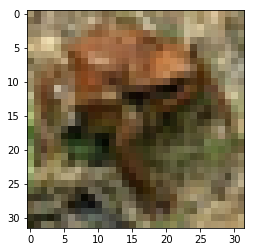

In [22]:
plt.imshow(ex2plot)
plt.show()

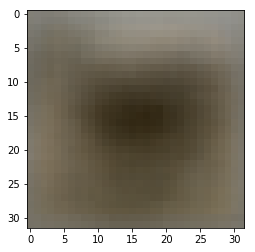

In [23]:
plt.imshow(res2plot)
plt.show()

## VAE

To reduce dimensionality of training set $X = \{x^{(i)}: x^{(i)} \in \mathbb{R}^D\}_{i=1}^n,$ from $D$ to $d$,
our probabalistic model is:


### $p(X, Z | \theta) = \prod_{i=1}^n\big(\prod_{k=1}^D \mathcal{N}(x_k^{(i)}|\mu_k(z^{(i)}), \sigma^2_k(z^{(i)}))\big)\mathcal{N}(z^{(i)}|0, I_d) = \prod_{i=1}^n\mathcal{N}(x^{(i)}|\theta(z^{(i)}))\mathcal{N}(z^{(i)}|0, I_d).$

Our task is to maximize $P(X|\theta)$. We re-express this as:

### $p(X|\theta) = \int q(Z| X)log(\frac{p(X, Z|\theta)}{q(Z|X)})dZ + D_{KL}(q \| p(Z|X,\theta)),$

And apply Variational Bayes, which finally gives us the following task:

### $\hat{\theta}, \hat{\phi} = argmax_{\theta, \phi}\hat{\mathcal{L}_V}(\theta, \phi) = argmax_{\theta, \phi} \big\{\mathbb{E}_{q(Z|X,\phi)}[log\ p(X,Z|\theta)] - D_{KL}[q(Z|X, \phi) \| p(Z|\phi)]\big\}, \text{where}\ q(Z|X, \phi) = \prod_{i=1}^n\big(\prod_{k=1}^d \mathcal{N}(z_k^{(i)}|\tilde{\mu}_k(x^{(i)}), \tilde{\sigma}^2_k(x^{(i)}))\big) = \prod_{i=1}^n\mathcal{N}(z^{(i)}|\phi(x^{(i)})).$

Here $\theta$ and $\phi$ are obtained by two FFNs (Decoder and Encoder).

To solve it we use block-wise SGD:

## $\triangledown_{\theta}\hat{\mathcal{L}_V}(\theta, \phi) \approx \frac{n}{m} \sum_{i=1}^m\triangledown_{\theta}log\ p(x^{(i)} | z^{(i)}_*, \theta);\ z^{(i)}_* \sim q(z^{{i}}|x^{(i)}, \phi),$

## $\triangledown_{\phi}\hat{\mathcal{L}_V}(\theta, \phi) \approx \frac{n}{m}\sum_{i=1}^m\big\{ \triangledown_{\phi}log\ p(x^{(i)}|g(\varepsilon^{(i)}_*, x^{(i)}, \phi), \theta) - \triangledown_{\phi} D_{KL}(r(\varepsilon_*^{(i)})\|p(z^{(i)}))\big\};\\\ \varepsilon^{(i)}_* \sim r(\varepsilon),$

where we re-expressed $z$ as $g(\varepsilon, x, \phi).$

In [6]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, hid_size):
        super(VariationalAutoEncoder, self).__init__()
        """
        :param inp_size: integer, dimension of the input object
        :param hid_size: integer, dimension of the hidden representation
        """
        self.hid_size = hid_size
        
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2, stride=2)
        self.enc_conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        self.features2hidden = nn.Linear(in_features=8192, out_features=128)
        self.hidden2mean = nn.Linear(in_features=128, out_features=hid_size)
        self.hidden2sigma = nn.Linear(in_features=128, out_features=hid_size)
        
        self.sample2compressed = nn.Linear(in_features=hid_size, out_features=128)
        self.compressed2features = nn.Linear(in_features=128, out_features=8192)
        
        self.dec_conv1 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1)
        
    def encode(self, x):
        """
        Encodes objects to hidden representations (E: R^inp_size -> R^latent_dim)

        :param x: inputs, Variable of shape (batch_size, inp_size)
        :return:  hidden represenation of the objects, Variable of shape (batch_size, la)
        """
        convolved_1 = F.relu(self.enc_conv1(x))
        convolved_2 = F.relu(self.enc_conv2(convolved_1))
        convolved_3 = F.relu(self.enc_conv3(convolved_2))
        
        flattened = convolved_3.view(convolved_3.size()[0], -1)
        hidden = F.relu(self.features2hidden(flattened))
        
        return self.hidden2mean(hidden), self.hidden2sigma(hidden)

    def decode(self, sample):
        """
        Decodes objects from samples of hidden space (D: R^hid_size -> R^inp_size)

        :param sample: samples of hidden represenatations, Variable of shape (batch_size, hid_size)
        :return:  reconstructed objects, Variable of shape (batch_size, inp_size)
        """
        compressed = F.relu(self.sample2compressed(sample))
        flattened_pict = F.relu(self.compressed2features(compressed))
        
        pict = flattened_pict.view(flattened_pict.size()[0], 32, 16, 16)
        deconvolved_1 = self.dec_conv1(pict)
        deconvolved_2 = self.dec_conv2(deconvolved_1)
        
        return self.dec_conv3(deconvolved_2)
        
    def forward(self, x):
        """
        Encodes inputs to hidden representations and decodes back.

        x: inputs, Variable of shape (batch_size, inp_size)
        return: reconstructed objects, Variable of shape (batch_size, inp_size)
        """
        self.d_params = self.encode(x)
        
        standard_normal = Normal(torch.zeros(x.size()[0], self.hid_size), 
                                      torch.ones(x.size()[0], self.hid_size))
        
        r = Variable(standard_normal.sample(), requires_grad=False)
        sample = r * self.d_params[1] + self.d_params[0]
        
        return self.decode(sample)
    
    def generate(self, n_examples):
        standard_normal = Normal(torch.zeros(n_examples, self.hid_size), 
                                      torch.ones(n_examples, self.hid_size))
        r = Variable(standard_normal.sample(), requires_grad=False)
        return self.decode(r)

    def vae_loss(self, recon_x, x):
        """
        Calculates the loss function for VAE.

        :params recon_x: reconstructed object, Variable of shape (batch_size, inp_size)
        :params x: original object, Variable of shape (batch_size, inp_size)
        :return: loss
        """
        flattened_x = x.view(x.size()[0],-1)
        flattened_recon_x = recon_x.view(recon_x.size()[0],-1)
        
        z_mean_2, z_sigma_2 = self.d_params[0] ** 2, self.d_params[1] ** 2
        
        kl_loss = -0.5 * torch.sum(1 + torch.log(z_sigma_2) - z_mean_2 - z_sigma_2, dim=1)
        
        diff = (flattened_x - flattened_recon_x) ** 2
        
        mse_loss = 0.5 * torch.sum(diff, dim=1)
        
        #print(torch.mean(kl_loss + mse_loss))
        return torch.mean(kl_loss + mse_loss)
    

In [7]:
model = VariationalAutoEncoder(4)

optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [8]:
for epoch in range(10):
    print('-'*10)
    print('EPOCH:', epoch)
    ave_loss = 0
    
    for batch_ix, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        normed_x, target = Variable(x/255), Variable(target)
        out = model(normed_x)
        loss = model.vae_loss(out, normed_x)
        #ave_loss = ave_loss * 0.9 + loss.data[0] * 0.1
        ave_loss += loss.data[0] / x.size()[0]
        loss.backward()
        optimizer.step()
        
        if (batch_ix+1) % 100 == 0 or (batch_ix+1)==len(train_loader):
            print('batch index:', batch_ix+1, 'avg train loss:', 1000*ave_loss/(batch_ix+1))

----------
EPOCH: 0
batch index: 100 avg train loss: 138.54334696233272
batch index: 200 avg train loss: 70.55200283080342
batch index: 300 avg train loss: 47.72513637493054
batch index: 400 avg train loss: 36.2249989736825
batch index: 500 avg train loss: 29.275384984761466
batch index: 600 avg train loss: 24.613095965981465
batch index: 700 avg train loss: 21.259147563789547
batch index: 800 avg train loss: 18.729538727831066
batch index: 900 avg train loss: 16.750311024321423
batch index: 1000 avg train loss: 15.158056631907794
----------
EPOCH: 1
batch index: 100 avg train loss: 0.7680609092116357
batch index: 200 avg train loss: 0.7341566650196917
batch index: 300 avg train loss: 0.7098210743318009
batch index: 400 avg train loss: 0.684312653634698
batch index: 500 avg train loss: 0.6606614128500228
batch index: 600 avg train loss: 0.6386629689484836
batch index: 700 avg train loss: 0.6183365566389903
batch index: 800 avg train loss: 0.6003410466481005
batch index: 900 avg train l

In [34]:
examples = model.generate(6).data.numpy()
examples.shape

(6, 3, 32, 32)

In [35]:
examples = np.rollaxis(examples, 1, 4)
examples.shape

(6, 32, 32, 3)

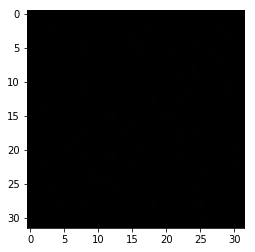

In [43]:
plt.imshow(examples[4])
plt.show()

In [ ]:
n = 15
img_size = 32
figure = np.zeros((img_size * n, img_size * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

        #plt.figure(figsize=(5, 5))
        #plt.imshow(img, cmap='Greys_r')
        #plt.show()


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()